In [1]:
import sys
sys.path.append("../")

from scripts.direct_training import direct_training
import matplotlib.pyplot as plt
import numpy as np
from plotting_utils import style_defaults, log_log, colour_gradient
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(style_defaults)

UNSCALED_COLOUR = "darkcyan"
SCALED_COLOUR = "hotpink"

In [2]:
direct_results = direct_training.to_dataframe(
    config=dict(
        dataset_name="Si-GAP-18",
        labels="dft",
        r_max=4,
    )
)
direct_results.groupby("n_train")[["test_force_rmse"]].count().T

n_train,25,50,100,200,400,800,1600
test_force_rmse,5,5,5,5,5,5,5


In [3]:
from scripts.alchemical_train import alchemical_train


pre_trained_models = {}

for r_max in (4, 6):
    df = alchemical_train.to_dataframe(
        config=dict(
            dataset_name="C-SYNTH-23M:reasonable",
            labels="ace",
            r_max=r_max,
            scale_factor=1.5,
        )
    )
    # dict of n_pretrain -> id
    pre_trained_models[r_max] = dict(zip(df.n_train, df.id))

pre_trained_models

{4: {100: '23.06.29-19.37.16-930520',
  330: '23.06.29-20.16.23-578801',
  1000: '23.06.29-20.47.24-291172',
  3300: '23.07.03-16.05.42-587979',
  10000: '23.07.04-05.49.45-594905'},
 6: {100: '23.06.28-19.46.50-432517',
  330: '23.06.28-22.39.25-814269',
  1000: '23.06.29-01.26.15-690272',
  3300: '23.06.29-14.11.44-365373',
  10000: '23.07.01-12.07.30-671895'}}

In [4]:
from scripts.fine_tuning import fine_tuning
from IPython.display import display
import pandas as pd


fine_tuned_results = {}
for r_max, models in pre_trained_models.items():
    results = {}
    for n_pretrain, pretrain_id in models.items():
        df = fine_tuning.to_dataframe(
            config=dict(
                pretrain_id=pretrain_id,
                finetune_dataset="Si-GAP-18",
                finetune_labels="dft",
                r_max=4,
            )
        )
        results[n_pretrain] = df

    fine_tuned_results[r_max] = results

for r_max, results in fine_tuned_results.items():
    print("scaled" if r_max == 4 else "unscaled")
    display(
        pd.concat(
            [
                df.groupby("n_finetune")[["test_force_rmse"]]
                .count()
                .rename(columns={"test_force_rmse": n_pretrain})
                .T
                for n_pretrain, df in results.items()
            ]
        )
    )


scaled


n_finetune,25,50,100,200,400,800,1600
100,5,5,5,5,5,5,5
330,5,5,5,5,5,5,5
1000,5,5,5,5,5,5,5
3300,5,5,5,5,5,5,5
10000,5,5,5,5,5,5,5


unscaled


n_finetune,25,50,100,200,400,800,1600
100,5,5,5,5,5,5,5
330,5,5,5,5,5,5,5
1000,5,5,5,5,5,5,5
3300,5,5,5,5,5,5,5
10000,5,5,5,5,5,5,5


# Plotting best models

In [5]:
best_direct_results = direct_results.groupby("n_train").min().reset_index()

best_fine_tuned_results = {}
for r_max, results in fine_tuned_results.items():
    best_fine_tuned_results[r_max] = {
        n_pretrain: df.groupby("n_finetune").min().reset_index()
        for n_pretrain, df in results.items()
    }

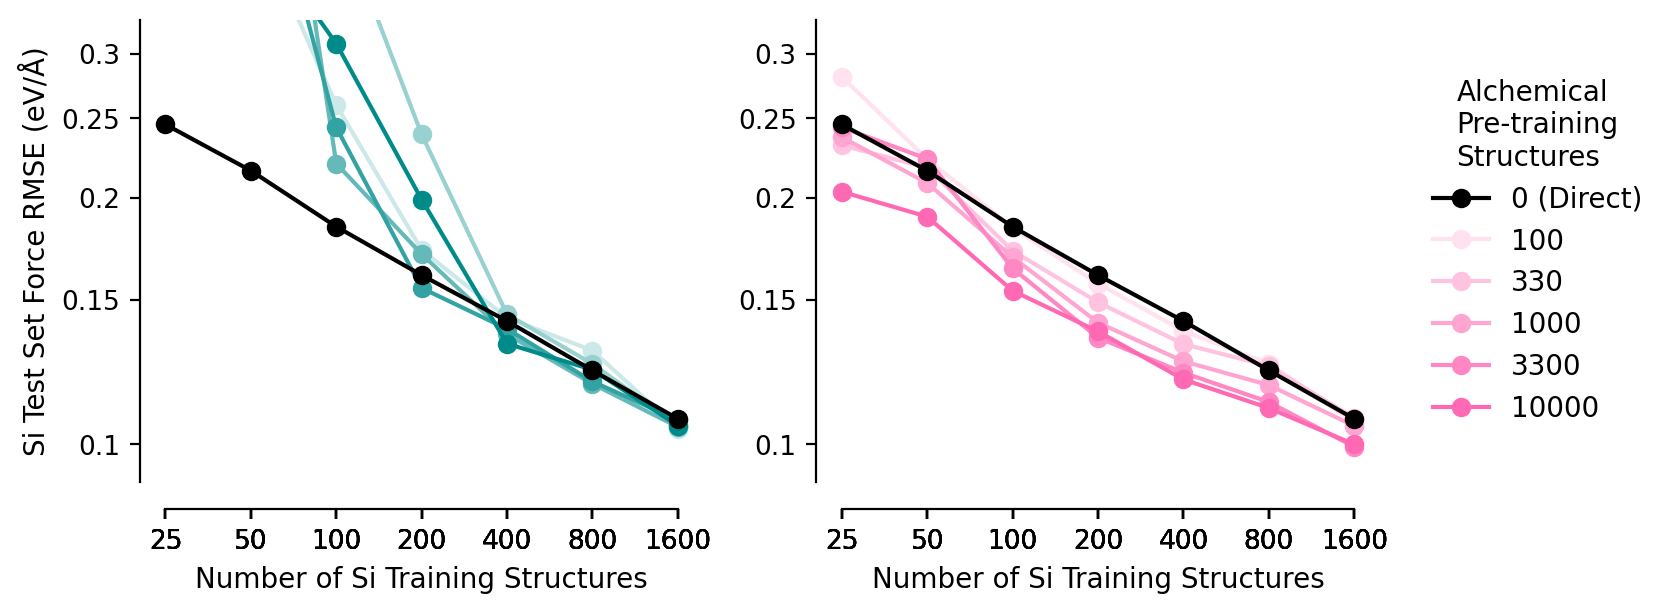

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 3))

for ax in axs:
    ax.plot(
        best_direct_results.n_train,
        best_direct_results.test_force_rmse,
        "-ok",
        label="0 (Direct)",
        zorder=10,
    )

# left plot
unscaled_results = best_fine_tuned_results[6]
for (n_pretrain, df), colour in colour_gradient(unscaled_results.items(), UNSCALED_COLOUR):
    axs[0].plot(
        df.n_finetune,
        df.test_force_rmse,
        "-o",
        color=colour,
    )
    
# right plot
scaled_results = best_fine_tuned_results[4]
for (n_pretrain, df), colour in colour_gradient(scaled_results.items(), SCALED_COLOUR):
    axs[1].plot(
        df.n_finetune,
        df.test_force_rmse,
        "-o",
        color=colour,
        label=n_pretrain,
    )

# tidy up
for ax in axs:
    xticks = list(direct_results.n_train)
    yticks = [0.1, 0.15, 0.2, 0.25, 0.3]
    log_log(xticks=xticks, yticks=yticks, ax=ax)
    ax.spines["bottom"].set_position(("outward", 10))
    ax.spines["bottom"].set_bounds(xticks[0], xticks[-1])
    ax.set_xlabel("Number of Si Training Structures")
    ax.set_ylim(0.09, 0.33)
    
axs[0].set_ylabel("Si Test Set Force RMSE (eV/Å)")
axs[1].legend(
    title="Alchemical\nPre-training\nStructures",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
)

plt.savefig("../figures/alchemy-curves.svg", bbox_inches="tight", transparent=True)

# Bar Chart

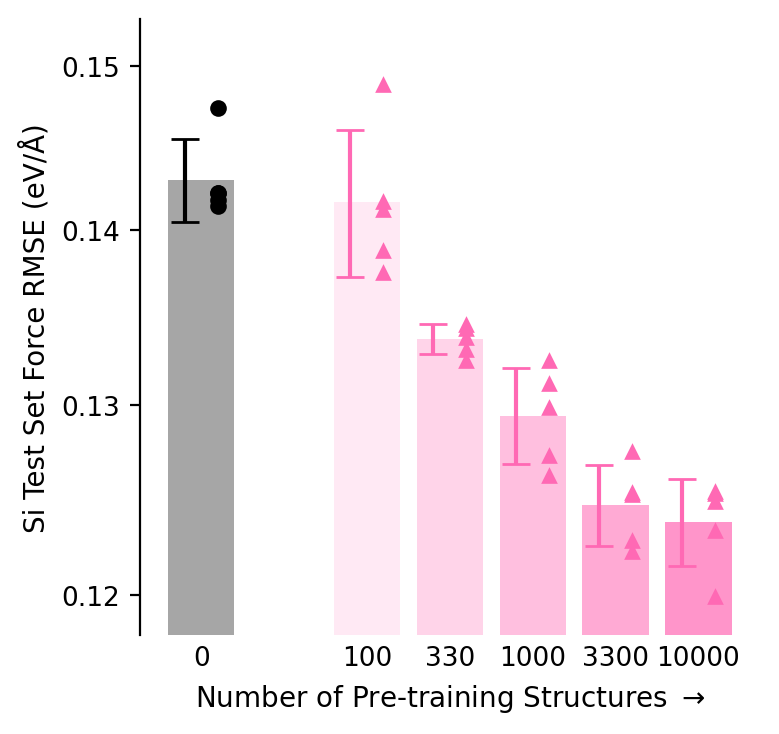

In [10]:
n_finetune = 400


def pretty_bar(x, y, bar_colour, highlight_colour, marker="o"):
    plt.bar(x, y.mean(), color=bar_colour, alpha=0.7)
    plt.errorbar(x - 0.2, y.mean(), yerr=y.std(), color=highlight_colour, capsize=5)
    plt.scatter([x + 0.2] * len(y), y, color=highlight_colour, lw=0, marker=marker)


direct_errors = direct_results[direct_results.n_train == n_finetune].test_force_rmse
pretty_bar(0, direct_errors, "gray", "black")

for i, ((n_pretrain, results), colour) in enumerate(
    colour_gradient(fine_tuned_results[4].items(), SCALED_COLOUR)
):
    fine_tuned_errors = results[results.n_finetune == n_finetune].test_force_rmse
    pretty_bar(i + 2, fine_tuned_errors, colour, SCALED_COLOUR, marker="^")


plt.xticks([0, 2, 3, 4, 5, 6], ["0", "100", "330", "1000", "3300", "10000"])
plt.ylabel("Si Test Set Force RMSE (eV/Å)")
plt.xlabel(r"Number of Pre-training Structures $\rightarrow$")
plt.gca().spines["bottom"].set_visible(False)
# make actual tick marks invisible
plt.gca().tick_params(axis="x", length=0)

plt.yscale("log")
yticks = [0.12, 0.13, 0.14, 0.15]
plt.yticks(yticks, [f"{y:.2f}" for y in yticks])
plt.ylim(0.118, 0.153)

plt.minorticks_off()

plt.savefig("../figures/alchemy-bar.svg", bbox_inches="tight", transparent=True)

# SOAP UMAP plots

In [10]:
from ase.io import read

# normal structures
unscaled_c = read(
    "../data/processed/C-SYNTH-23M:reasonabletransmuted:Si-1.0/ace/test.extxyz",
    index=":",
)

# scaled structures
scaled_c = read(
    "../data/processed/C-SYNTH-23M:reasonabletransmuted:Si-1.5/ace/test.extxyz",
    index=":",
)

# true si structures
si = read("../data/processed/Si-GAP-18/dft/test.extxyz", index=":")


In [11]:
len(unscaled_c), len(scaled_c), len(si)

(1000, 1000, 247)

In [12]:
import numpy as np
from quippy.descriptors import Descriptor

soap_desc = Descriptor("soap cutoff=4.0 l_max=6 n_max=6 atom_sigma=0.5 n_Z=1 Z={14}")

unscaled_soaps = np.vstack([soap_desc.calc_descriptor(atoms) for atoms in unscaled_c])
scaled_soaps = np.vstack([soap_desc.calc_descriptor(atoms) for atoms in scaled_c])
si_soaps = np.vstack([soap_desc.calc_descriptor(atoms) for atoms in si])

unscaled_soaps.shape, scaled_soaps.shape, si_soaps.shape

((200000, 148), (200000, 148), (17295, 148))

In [16]:
from umap import UMAP


umap = UMAP(n_components=2, random_state=42, n_neighbors=4)

representative_idxs = np.random.RandomState(42).choice(
    len(si_soaps), size=5000, replace=False
)

c_embedding = umap.fit_transform(
    np.vstack(
        [
            unscaled_soaps[representative_idxs],
            scaled_soaps[representative_idxs],
        ]
    ),
)
si_embedding = umap.transform(si_soaps[representative_idxs])

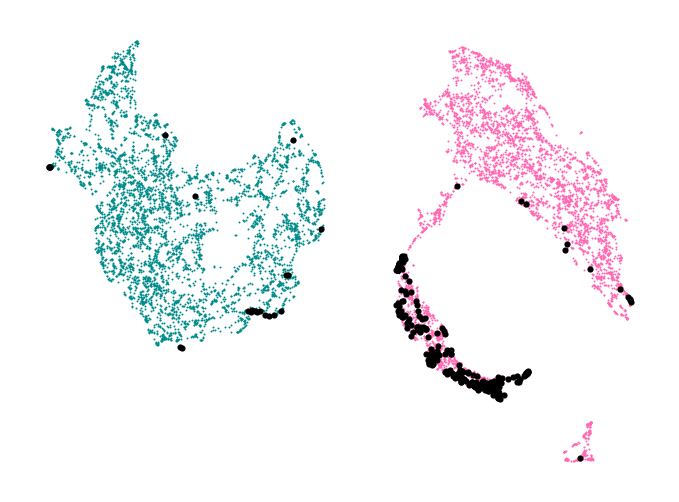

In [ ]:
plt.figure(figsize=(6, 3))

n_to_plot = 5_000
plt.scatter(
    *c_embedding[:n_to_plot].T,
    s=0.5,
    lw=0,
    label="Unscaled C",
    c="darkcyan",
)
plt.scatter(
    *c_embedding[5000 : 5000 + n_to_plot :].T,
    s=0.5,
    lw=0,
    label="Scaled C",
    c="hotpink",
)
plt.scatter(*si_embedding[:400].T, s=5, lw=0, label="Si", c="k")

plt.gca().set_aspect("equal")
plt.axis("off")
plt.gca().invert_xaxis()

plt.savefig("../figures/alchemy-umap.svg", bbox_inches="tight", transparent=True)
